# Computing a simple alpha factor and its IC

22/12/2025

In this notebook I'll be handling data to calculate the 12 month momentum of different stocks as a possible alpha factor. The alpha factor could be defined as follows:

"For a given day, the highest 12 month momentum ticker will deliver the highest returns in 21 days".

I'll be using the information coefficient to gauge the value of this alpha factor, which is explained below.

The Information Coefficient (IC) in finance measures an analyst's or model's forecasting skill by calculating the correlation between predicted returns and actual subsequent returns, helping to validate alpha models and manager performance. It's a key metric for assessing predictive power, showing how well rankings of stocks (e.g., "best to worst") align with their actual performance. 

### How it works
Calculation: It's typically a correlation coefficient (like Spearman's rank correlation) between the forecasted rankings or scores of assets and their actual realized returns over a period.

### Interpretation
+1: Perfect positive correlation (predictions consistently right).\
0: No correlation (no better than random guessing).\
-1: Perfect negative correlation (always predicts the opposite).

### Key applications
- Evaluating Alpha Models: Tests if a quantitative model's "alpha" (skill-based return) is reliable.
- Measuring Manager Skill: Assesses if a portfolio manager consistently picks winners.
- Portfolio Construction: Helps decide whether to rely more on strong signals (high IC) or a broader range of signals (breadth). 

In [1]:
import sys
sys.path.append(r"C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src")
import quant_utils as qu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'AVGO']
data = qu.data.download_data(tickers)

Saved → C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src\data\AAPL_TSLA_MSFT_NVDA_AVGO_max_1d.pkl


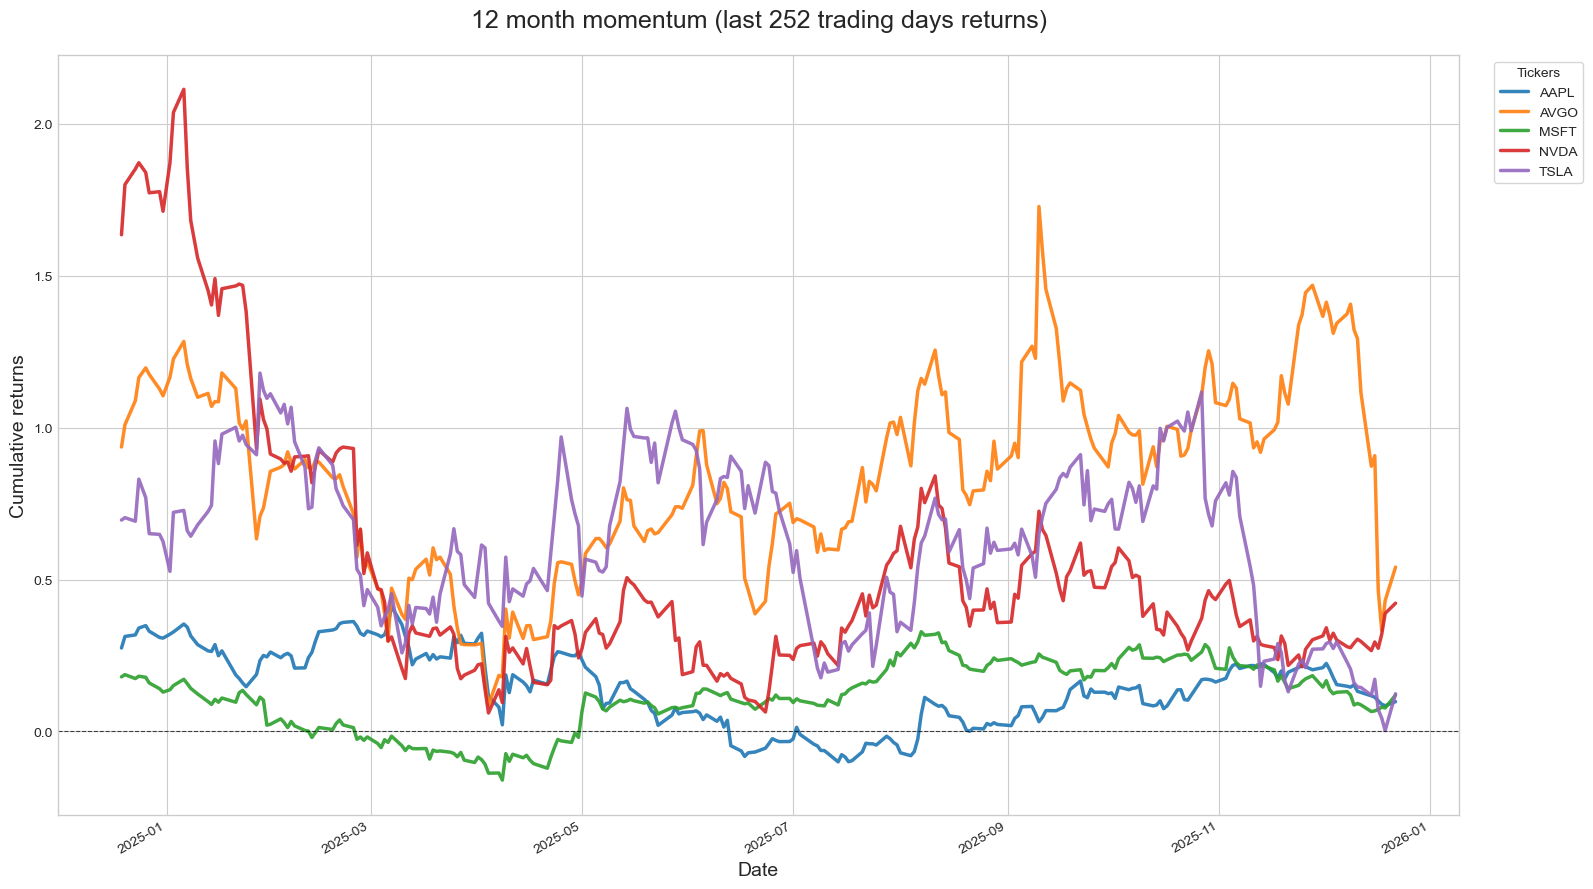

In [3]:
# Calculating rolling momentum for 12 months as alpha factor
n = 1 
days_per_year = 252 
rol_window = n * days_per_year

momentum = data.pct_change(periods=rol_window, fill_method=None).dropna()
momentum_last_year = momentum.tail(rol_window)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 9))
momentum_last_year.plot(ax=ax, linewidth=2.5, alpha=0.9)

ax.set_title('12 month momentum (last 252 trading days returns)', fontsize=18, pad=20)
ax.set_ylabel('Cumulative returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(title='Tickers', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Interpretation

This chart alone is not significant for trading purposes. 
As the principle states: "past returns do not guarantee future returns."

What this plot shows:
- Historical momentum patterns for each ticker
- Relative performance differences between stocks
- Periods of high/low momentum

What we DON'T know yet (and need to validate):
- Signal quality: How much is real signal vs noise?
- Signal persistence: How long does momentum predict future returns before decaying?
- Predictive power: Is there actual correlation between current momentum and forward returns?

To answer these questions, we'll calculate the Information Coefficient (IC) - 
the correlation between today's momentum and future returns at various horizons.

In [4]:
# Measuring Information Coefficient (IC)

from scipy.stats import spearmanr

# Preparing the dataframe
forward_horizon = 21
momentum = data.pct_change(periods=252, fill_method=None).shift(1).rank(pct=True, axis=1).dropna()
forward_returns = data.pct_change(forward_horizon, fill_method=None).shift(-forward_horizon).rank(pct=True, axis=1).dropna()

# Cross-sectional comparison
ic_values = []
valid_dates = []
common_dates = momentum.index.intersection(forward_returns.index)
mom_h = momentum.loc[common_dates]
fwd_h = forward_returns.loc[common_dates]

for date in common_dates:
        factor_cs = mom_h.loc[date]
        fwd_cs = fwd_h.loc[date]
        mask = factor_cs.notna() & fwd_cs.notna()

        if mask.sum() >= 2:
            ic = spearmanr(factor_cs[mask],fwd_cs[mask])[0]
            ic_values.append(ic)
            valid_dates.append(date)

ic_series = pd.Series(ic_values, index=valid_dates)

print(f"\n{'='*60}")
print("Information coefficient results")
print(f"{'='*60}")
print(f"Average IC: {ic_series.mean():.4f}")
print(f"Median IC: {ic_series.median():.4f}")
print(f"Std IC: {ic_series.std():.4f}")
print(f"T-stat: {ic_series.mean() / ic_series.std() * np.sqrt(len(ic_series)):.2f}")


Information coefficient results
Average IC: 0.0496
Median IC: 0.1000
Std IC: 0.5524
T-stat: 5.41


## Interpretation

An **average IC of 0.0496** indicates modest but genuine predictive power; this is in the range typically seen for usable single factors evaluated on daily data across a reasonable universe.

A **median IC of 0.1000**, higher than the mean, suggests a distribution that is somewhat skewed to the upside: on many days the factor works quite well, but there are weaker or occasionally negative episodes that pull the average down.

The **standard deviation of 0.5524**, much larger than the mean, reflects a very noisy environment, which is normal for daily cross‑sectional ICs; the day‑to‑day correlation varies a lot even if the long‑run average is positive.

The **t‑statistic of 5.41** shows that, despite the noise, the signal is statistically significant; you can comfortably reject the null hypothesis of zero average IC and conclude that the factor contains exploitable predictive information.